In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import loompy
from collections import Counter

In [2]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.7.1 anndata==0.7.5 umap==0.4.6 numpy==1.19.2 scipy==1.5.2 pandas==1.1.3 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.7.1 louvain==0.7.0 leidenalg==0.7.0


In [3]:
data = sc.read_loom("./rgl_neuroblast_glioblast.loom")
data.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


"Cells belonging to a clade of the dendrogram containing glia (clusters 172-320) were pulled from the dataset."

In [4]:
adata = data[(data.obs.Clusters < 321)]
adata.var_names_make_unique()

"Cells with fewer than 2000 UMIs were excluded from pooling."

In [5]:
adata = adata[(adata.obs.TotalUMI > 2000)]

/Users/lisa/opt/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
normalizing counts per cell
    finished (0:00:00)


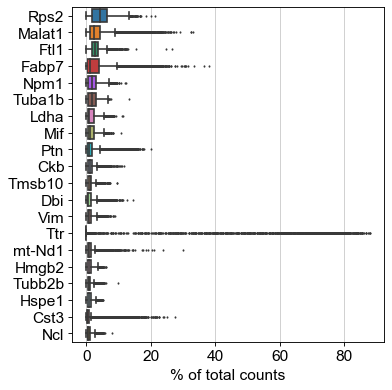

In [6]:
#Show those genes that yield the highest fraction of counts in each single cell, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20, )

Basic filtering : we keep cells who express a least 200 genes and genes expressed in at least 10 cells and at most 60% of cells


In [7]:
sc.pp.filter_genes(adata, max_cells = 0.6*adata.shape[0])
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=10) 

filtered out 89 genes that are detected in more than 34725.0 cells
filtered out 18152 cells that have less than 200 genes expressed
filtered out 982 genes that are detected in less than 10 cells


High proportions of mitochondrial genes are indicative of poor-quality cells. Thus we look at the percentage of mitochondrial genes per cell, and we remove the cells when they expressed more than 5% of mitochondrial genes.

In [8]:
adata.var['mt'] = adata.var_names.str.startswith('mt-') # annotate the group of mitochondrial genes as 'mt'

... storing 'Age' as categorical
... storing 'Chemistry' as categorical
... storing 'ChipID' as categorical
... storing 'Class' as categorical
... storing 'Date_Captured' as categorical
... storing 'DonorID' as categorical
... storing 'Label' as categorical
... storing 'Plug_Date' as categorical
... storing 'Project' as categorical
... storing 'PseudoTissue' as categorical
... storing 'Punchcard' as categorical
... storing 'Region' as categorical
... storing 'SampleID' as categorical
... storing 'SampleName' as categorical
... storing 'Sample_Index' as categorical
... storing 'Sex' as categorical
... storing 'Species' as categorical
... storing 'Strain' as categorical
... storing 'Subset' as categorical
... storing 'Tissue' as categorical
... storing 'Transcriptome' as categorical
... storing 'cDNA_Lib_Ok' as categorical
... storing 'ngperul_cDNA' as categorical
... storing 'Chromosome' as categorical
... storing 'Strand' as categorical


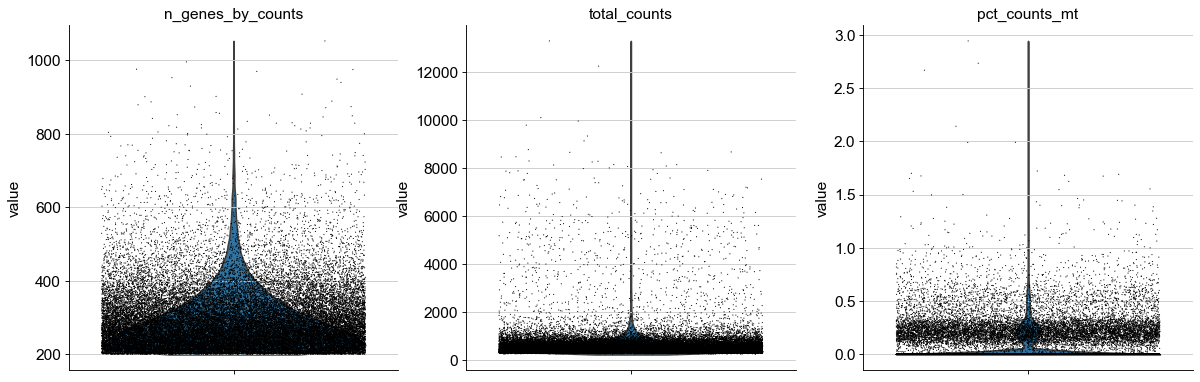

In [9]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

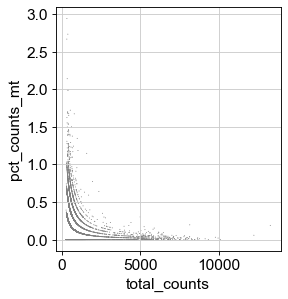

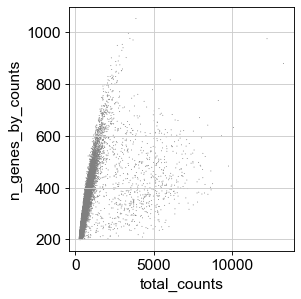

In [10]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

We remove cells that have too many mitochondrial genes or too many total counts

In [11]:
adata = adata[adata.obs.n_genes_by_counts < 700, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

We total-count normalize the data matrix to 10'000 reads per cell, so that counts become comparable among cells.

In [12]:
#Normalize
sc.pp.normalize_total(adata, target_sum=1e4)

/Users/lisa/opt/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
normalizing counts per cell
    finished (0:00:00)


We logarithmize the data :

In [13]:
#Logarithmize the data
sc.pp.log1p(adata)

Next, we identify the highly-variable genes.

In [14]:
#Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


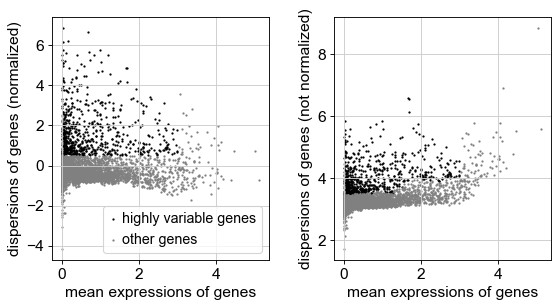

In [15]:
sc.pl.highly_variable_genes(adata)


Do the filtering:

In [16]:
adata.raw = adata

In [17]:
adata = adata[:, adata.var.highly_variable]

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [18]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:23)


In [19]:
sc.pp.scale(adata, max_value=10)

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


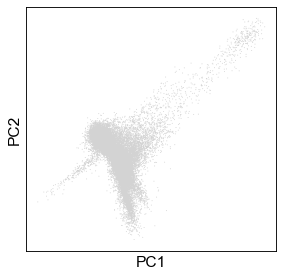

In [20]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata)

We now inspect the contribution of single PCs to the total variance in the data. We conclude that 40PCs should be enough. 

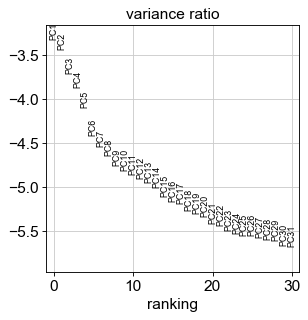

In [21]:
sc.pl.pca_variance_ratio(adata, log=True)

In [22]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:17)


In [23]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:17)


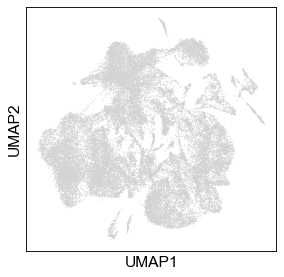

In [24]:
sc.pl.umap(adata)

In [25]:
sc.tl.leiden(adata, 0.5)

running Leiden clustering
    finished: found 23 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:13)


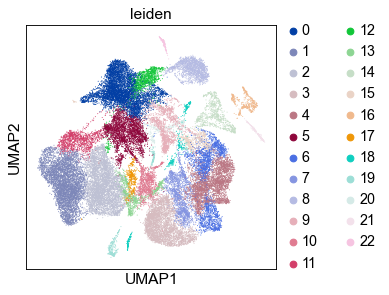

In [26]:
sc.pl.umap(adata, color=['leiden'] )

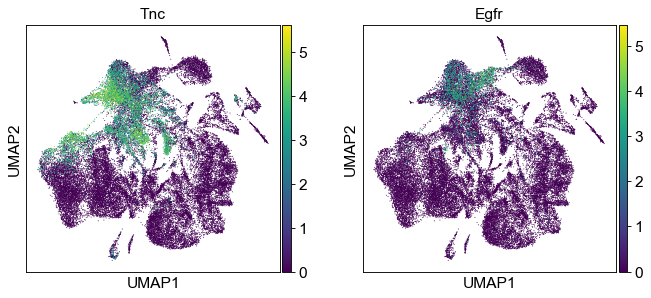

In [27]:
sc.pl.umap(adata, color=['Tnc', 'Egfr'] )

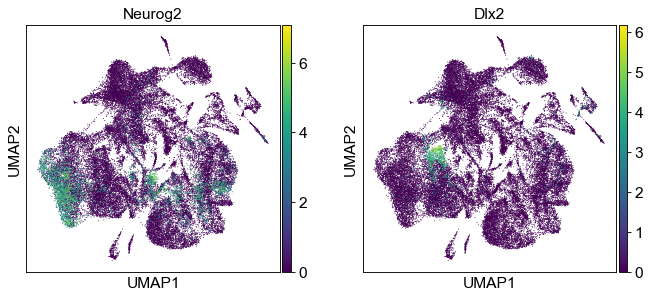

In [28]:
sc.pl.umap(adata, color=['Neurog2', 'Dlx2'] )

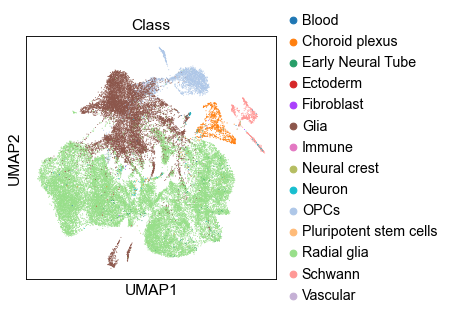

In [29]:
sc.pl.umap(adata, color=['Class'])

Aditionnal analysis

In [30]:
# Getting cell types frequencies for each developmental age
types_per_age = (adata.obs 
                     # Grouping annotation dataframe by age and cell type
                     .groupby(['Age', 'Class'])
                     # Count number of cells in each group
                     .count()
                     # Pivot the table such Age is index, and CellType are columns
                     .unstack('Class')['ChipID']
                     # Fill NaN values with zeros
                     .fillna(0)
                )

Text(0.5, 0, 'Age')

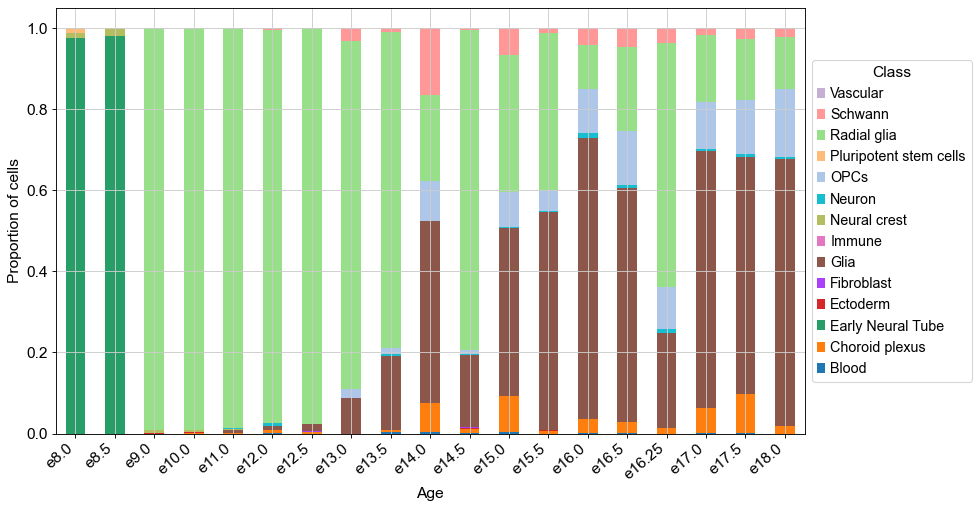

In [31]:
import matplotlib.pyplot as plt
# Normalize columns so the values will be proportions
types_per_age = types_per_age.div(types_per_age.sum(axis=1), axis=0)

# Plotting stacked barplot
f, ax = plt.subplots(figsize=(15, 7))
types_per_age.plot.bar(ax=ax, stacked=True)

# Shrinking current axis by 20% and putting legend our of the plot
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Class', loc='center left', bbox_to_anchor=(1, 0.5))

# Setting angled xticklabels
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, horizontalalignment='right')

# Setting axis labels
ax.set_ylabel('Proportion of cells')
ax.set_xlabel('Age')

Dynamical modeling


In [32]:
import scvelo as scv
scv.logging.print_version()

Running scvelo 0.2.3 (python 3.8.5) on 2021-06-01 12:56.


In [33]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  # for beautified visualization

In [34]:
adata = scv.read('../scvelo_final1.h5ad')

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


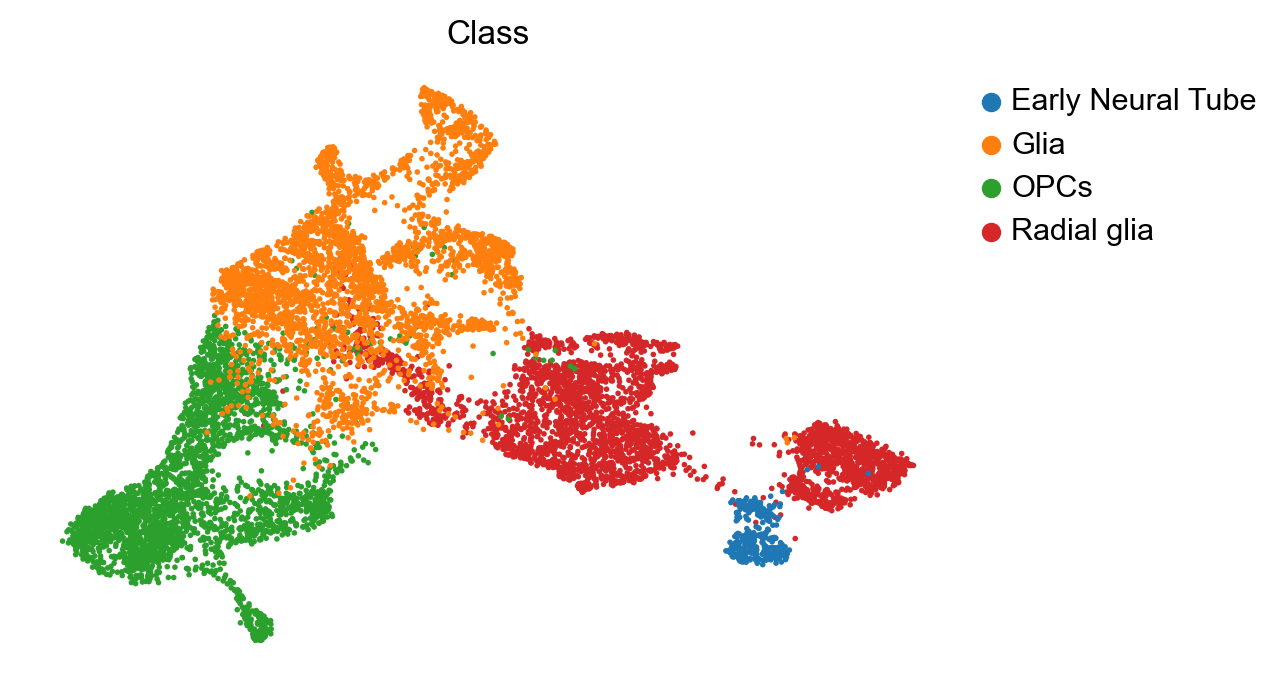

In [35]:
scv.tl.umap(adata)
scv.pl.umap(adata, color=['Class'])

computing terminal states
    identified 3 regions of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:03) --> added 
    'latent_time', shared time (adata.obs)


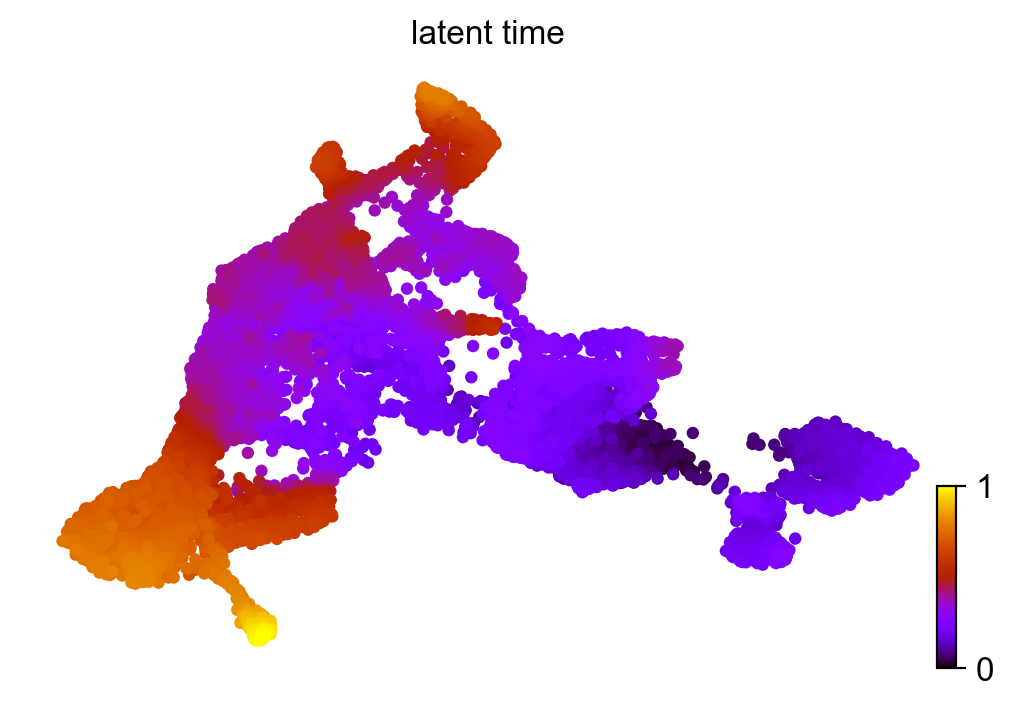

In [36]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80)